## Load Data and Libraries


In [1]:
# load libraries
import os
import gc
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns
import time


# import metrics, random forest, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, classification_report, recall_score,precision_score, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, PrecisionRecallDisplay, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

# import roccurve display



In [2]:
# load custom functions
from models_util import ml_helper as mlh

In [5]:
# data and seed as global parameteters
data_type = "SCBC" # either SCBC or ABMS 
classifier_type = "Proteoform" # protein or 'Proteoform' classifiers
analysis_type =  "Proteoform" # either "Proteoform" or "Sims"  or "Protein" - which full table to load 
seed = 453 #345 

# drop columns unecessary for classication when splitting X and y 
drop_cols = ["Var1", "Var2", "db"]

#### IMPORTANT #### set it to FALSE to skip the prediction of the all the possible PP pairs.
RUN_WHOLE_TABLE = True # set to true to run the whole table of the specific data type (either subcell or total cell) for either protein or proteoform analysis 

In [ ]:
# load data for training the classifier
if classifier_type == "Protein":
    scbc = pd.read_csv(os.getcwd() + "\\data\\features_protein\\scbc_protein_features_db.csv", index_col=0)
    abms = pd.read_csv(os.getcwd() + "\\data\\features_protein\\abms_protein_features_db.csv", index_col=0)

elif classifier_type == "Proteoform":
    abms = pd.read_csv(os.getcwd() + "\\data\\features_sim\\abms_sim_features_db2.csv", index_col=0)
    scbc = pd.read_csv(os.getcwd() + "\\data\\features_sim\\scbc_sim_features_db2.csv", index_col=0)

else:
    raise RuntimeError("Specify either `Protein` or `Proteoform` as a classifier type")


####  IMPORTANT ####
# Select data for analysis 
if data_type == "ABMS":
    data = abms
elif data_type == "SCBC":
    data = scbc
else:
    raise RuntimeError("Specify either 'SCBC' or 'ABMS' as a data type")

In [18]:
# ## Other datasets
# scbc = pd.read_csv(os.getcwd() + "\\data\\features_sim\\scbc_sim_features_db2.csv", index_col=0)
# data=scbc

# ## AML dataset
# aml = pd.read_csv(os.getcwd() + "\\data\\aml_features\\aml_prot_features_dbcorum.csv", index_col=0)
# data = aml

# # aml_vae = abms.loc[:,~abms.columns.str.contains("raw")].drop(drop_cols, axis=1).columns.tolist()
# # aml_raw = abms.loc[:,abms.columns.str.contains("raw")].columns.tolist()
# aml_vae_common = ['ABMS_vae_cor_pears', 'ABMS_vae_cor_spear', 'ABMS_vae_cos', 'ABMS_vae_euc', 'ABMS_vae_man',
#  'ABMS_vae_std_dif']
# aml_simple_raw = ['ABMS_raw_cor_pears',
#                   'ABMS_raw_euc',
#                   'ABMS_raw_man',
#                   'ABMS_raw_std_dif']

## Tuned RF Classifier and Feature Importance (one seed)
- I kept the top features for now based on both permutation and entropy-based importance. The proteoform and protein classifiers align in terms of importance. The latter was trained with dominant proteoform which correspond to unique gene IDs.
- I extracted and pasted the lists after importance analysis below.
- The importance analysis (on multiple seeds for a model) is in the last part of this file.
- Furthermore, I compared the differences between models using only VAE embeddings, only raw data, and their combination—focusing on features shared by both VAE and raw data. I used a RF model for importance and a linear model for auc scorig (since the number of features affect greatly the hyperparameteres of a random forest). 
- I realized that the combination of features increases the Linear model's performance, and discarded those that are not usefull.
- So, for the final feature combination I compared the Linear and RF models when they were tuned. 
- There is a small difference between the L2-model and the RF in the ROC-auc giving a rationalization of the model's choice. I observed a difference in the L2 model's recall of the positive class, presenting a higher metric than that of the negative class. I decided to stay with the random forest because it gave more balanced metrics since there is a cost for flase positives in this particular sceme. 

In [ ]:
# lists for comparisons 
# scbc_raw = ['SCBC_raw_cor_pears', 'SCBC_raw_cor_spear','SCBC_raw_man', 'SCBC_raw_std_dif', "SCBC_raw_euc", "SCBC_raw_cos"]
# scbc_rawtop =  ['SCBC_raw_cor_pears', 'SCBC_raw_cor_spear','SCBC_raw_man', 'SCBC_raw_std_dif']
# scbc_vae_common =  ['SCBC_vae_cor_pears',
#  'SCBC_vae_cor_spear',
#  'SCBC_vae_cos',
#  'SCBC_vae_euc',
#  'SCBC_vae_man',
#  'SCBC_vae_std_dif']
# scbc_vae = scbc.loc[:,~scbc.columns.isin(scbc_raw)].drop(drop_cols, axis=1).columns.tolist()

In [ ]:
# abms_vae = abms.loc[:,~abms.columns.str.contains("raw")].drop(drop_cols, axis=1).columns.tolist()
# abms_raw = abms.loc[:,abms.columns.str.contains("raw")].columns.tolist()
# abms_vae_common = ['ABMS_vae_cor_pears', 'ABMS_vae_cor_spear', 'ABMS_vae_cos', 'ABMS_vae_euc', 'ABMS_vae_man',
#  'ABMS_vae_std_dif']

In [ ]:
abms_top = [
'ABMS_raw_cor_spear',
 'ABMS_raw_man',
 'ABMS_raw_std_dif',
 'ABMS_raw_cos',
 'ABMS_vae_cos',
 'ABMS_vae_cor_spear',
 'ABMS_umap_euc',
 'ABMS_umap_cos',
 'ABMS_vae_std_dif']

In [8]:
# # selected deatures for scbc datatype (both proteoform and protein classifiers)
scbc_top= ['SCBC_umap_euc',
 'SCBC_vae_cor_spear',
 'SCBC_vae_cos',
 'SCBC_raw_cor_spear',
 'SCBC_raw_cor_pears',
 'SCBC_raw_man',
 'SCBC_raw_std_dif',
 'SCBC_umap_cos'
 ]


### Classifier
- Use either ABMS-top or SCBC-top features for the classifiaction.
- Then predict all the possible inteeractions from the whole proteoform matrices using the RF classifier.
- Hyperparameters for the SCBC-rf :  500 trees, min_sample_leaf=2, max_features = 0.4, max_depth=None
- Hyperparameters for the ABMS-rf :  500 trees, min_sample_leaf=5, max_features = 0.4, max_depth=None

Classifier operates on undersample data
0.8401647843287391
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      2592
           1       0.75      0.76      0.76      2612

    accuracy                           0.76      5204
   macro avg       0.76      0.76      0.76      5204
weighted avg       0.76      0.76      0.76      5204

['SCBC_umap_euc' 'SCBC_vae_cor_spear' 'SCBC_vae_cos' 'SCBC_raw_cor_spear'
 'SCBC_raw_cor_pears' 'SCBC_raw_man' 'SCBC_raw_std_dif' 'SCBC_umap_cos']


Text(0, 0.5, 'True Positive Rate')

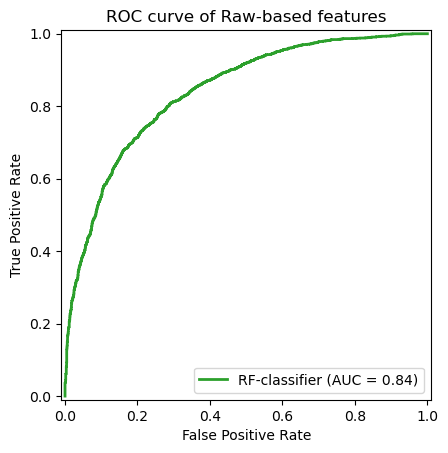

In [ ]:
# based on global parameters above
seed = seed
selected_cols = scbc_top # top features for prediction  
scale_data = True
imbalance_factor = None

# sample from the data and undersample the negative class by random shuffling
pos_df = data[data["db"] == 1]
neg_df = data[data["db"] == 0]

if imbalance_factor is not None:
    neg_df = neg_df.sample(n=pos_df.shape[0]*imbalance_factor, random_state=seed)
else:
    neg_df = neg_df.sample(n=pos_df.shape[0], random_state=seed) # 1 to 1 ratio via undersampling 

data_sample = pd.concat([pos_df, neg_df])
del pos_df, neg_df

# shuffle the data
data_sample = data_sample.sample(frac=1, random_state=seed)

# subset columns of data df based on regex
if selected_cols is not None:
    X_df = data_sample[selected_cols]
    X = data_sample[selected_cols]
else:
    X_df = data_sample.drop(columns=drop_cols)
    X = data_sample.drop(columns=drop_cols)

y = data_sample["db"]

# scale the data and create a df again
if scale_data is True:
    X = StandardScaler().fit_transform(X)
    X = pd.DataFrame(X, columns=X_df.columns)



# split train-test sets from this seed 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
del X,y,X_df
gc.collect()

# here we deal with imbalance if applied
if imbalance_factor is not None:
    print(f"Operating smote to minority class with a factor of {imbalance_factor}")
    smote = SMOTE(random_state=seed)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    print("Class distribution after SMOTE:")
    print(pd.Series(y_train).value_counts())
else:
    print("Classifier operates on undersample data")
cv = StratifiedKFold

rf = RandomForestClassifier(n_estimators=500,
                            max_features=0.4, 
                            criterion="entropy",
                            random_state=seed,
                            min_samples_leaf=2,
                            class_weight="balanced",
                            max_depth=None,
                            n_jobs=7)
rf.fit(X_train, y_train)
rf.feature_importances_

y_predprob = rf.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_predprob))

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

print(rf.feature_names_in_)

# plot ROC curve for the linear classifier using sklearn
roc_rf = RocCurveDisplay.from_estimator(
    rf, X_test, y_test, name="RF-classifier", color="tab:green", lw=2
)

roc_rf.ax_.set_title("ROC curve of Raw-based features")
roc_rf.ax_.set_xlabel("False Positive Rate")
roc_rf.ax_.set_ylabel("True Positive Rate")

In [10]:
# linear model comparison - high recall in positive class may lead to more false positives (SCBC data)

classifier_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(penalty="l2", solver="liblinear", random_state=seed))
    ])

param_grid = {
        'logreg__C': [0.0005,0.005,0.01,0.05,0.1,1]
    }
# create a cv fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# recall of positive class
score_test = make_scorer(recall_score, pos_label=1)

grid = GridSearchCV(classifier_pipe, param_grid, cv=10, scoring="roc_auc", n_jobs=7, verbose=1)

grid.fit(X_train, y_train)

model_best = grid.best_estimator_
Y_pred3 = model_best.predict(X_test)
print("Linear Classisifier\n",classification_report(y_test, Y_pred3))
Y_predprob3 = model_best.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, Y_predprob3))
print(grid.best_params_)




Fitting 10 folds for each of 6 candidates, totalling 60 fits
Linear Classisifier
               precision    recall  f1-score   support

           0       0.76      0.68      0.72      2592
           1       0.71      0.78      0.75      2612

    accuracy                           0.73      5204
   macro avg       0.73      0.73      0.73      5204
weighted avg       0.73      0.73      0.73      5204

0.8073891512109352
{'logreg__C': 1}


In [11]:
# feature importance using permutation
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=7
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_test.columns.to_list())

Elapsed time to compute the importances: 15.073 seconds


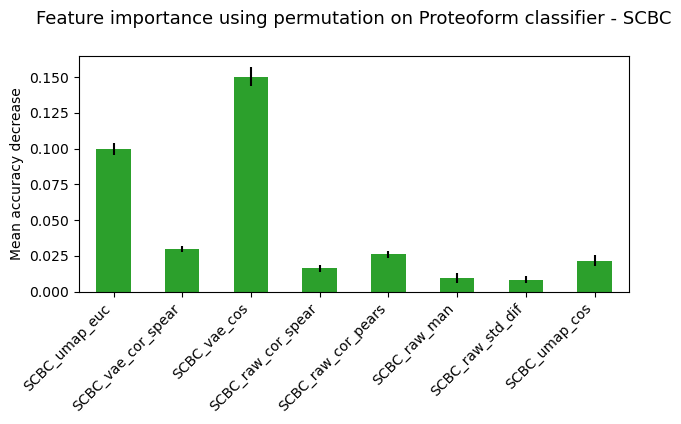

In [12]:


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color="tab:green")
ax.set_title(f"Feature importance using permutation on {classifier_type} classifier - {data_type}", fontsize=13, y=1.1)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.show()

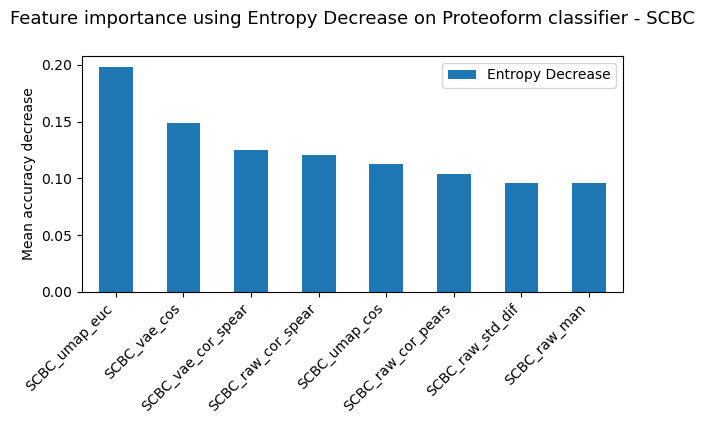

In [13]:
importance_df = pd.DataFrame(rf.feature_importances_, index=X_test.columns, columns=["Entropy Decrease"])
importance_df = importance_df.sort_values(by="Entropy Decrease", ascending=False)
# feature_list_imp = list(importance_df.head(10).index)


fig, ax = plt.subplots()
importance_df.plot.bar (ax=ax, color="tab:blue")
ax.set_title(f"Feature importance using Entropy Decrease on {classifier_type} classifier - {data_type}", fontsize=13, y=1.1)
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.xticks(rotation=45, ha="right")
plt.show()

## Probability Threshold of Classifier (FDR < 0.05)
- Based on the test set I will find the threshold usin a custom bisection search algorith with tolerance of 0.005.
- It starts with a p threshold of 0.5.
- Using a nested function, it computes the FPR, TPR, Recall as well as plot the confusion matrix in that threshold.
- Next, given a FDR tolerance it computes the difference between the desired FRD threshold and the actual FDR.
- It changes the minimum or maximum value and performs a new iteration of a bisection search. 

Iteration 0: threshold=0.7500, FDR=0.1295, TPR=0.4399, FPR=0.0660
Iteration 1: threshold=0.8750, FDR=0.0647, TPR=0.2546, FPR=0.0177
Iteration 2: threshold=0.8125, FDR=0.0982, TPR=0.3480, FPR=0.0382
Iteration 3: threshold=0.7812, FDR=0.1177, TPR=0.3959, FPR=0.0532
Iteration 4: threshold=0.7969, FDR=0.1078, TPR=0.3740, FPR=0.0455
Iteration 5: threshold=0.8047, FDR=0.1013, TPR=0.3599, FPR=0.0409
Iteration 6: threshold=0.8008, FDR=0.1040, TPR=0.3660, FPR=0.0428

Optimal threshold found: 0.801
TPR: 0.366, FPR: 0.043, FDR: 0.104


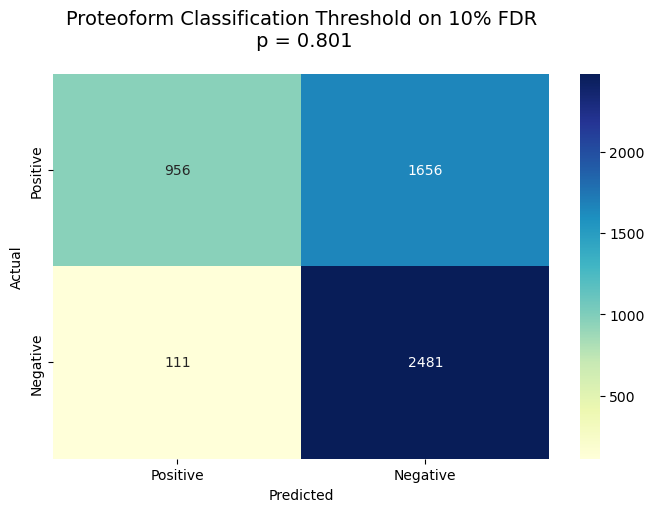

In [14]:
mlh.get_probthreshold(y_test,
                      y_predprob,
                      classifier_type=classifier_type,
                      target_FDR=0.10,
                      fdr_tol=0.005,
                      tol=0.005,
                      max_iter=50)

Iteration 0: threshold=0.7500, FDR=0.1295, TPR=0.4399, FPR=0.0660
Iteration 1: threshold=0.8750, FDR=0.0647, TPR=0.2546, FPR=0.0177
Iteration 2: threshold=0.9375, FDR=0.0423, TPR=0.1562, FPR=0.0069
Iteration 3: threshold=0.9062, FDR=0.0538, TPR=0.2021, FPR=0.0116
Iteration 4: threshold=0.8906, FDR=0.0573, TPR=0.2266, FPR=0.0139
Iteration 5: threshold=0.8984, FDR=0.0578, TPR=0.2121, FPR=0.0131
Iteration 6: threshold=0.9023, FDR=0.0526, TPR=0.2067, FPR=0.0116

Optimal threshold found: 0.902
TPR: 0.207, FPR: 0.012, FDR: 0.053


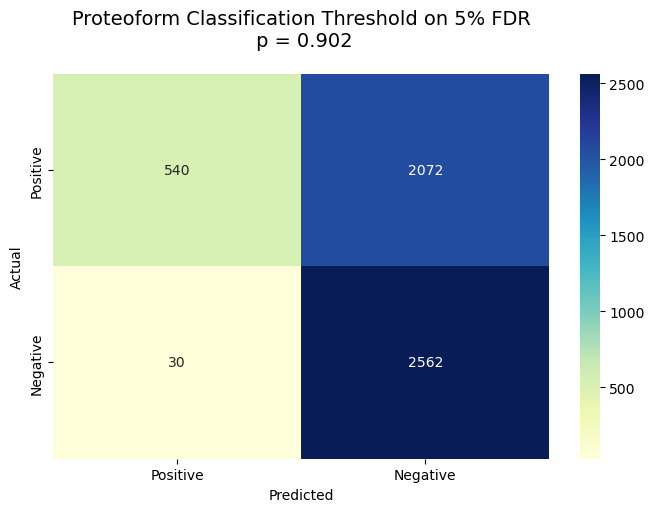

In [15]:
mlh.get_probthreshold(y_test,
                      y_predprob,
                      classifier_type=classifier_type,
                      target_FDR=0.05,
                      fdr_tol=0.005,
                      tol=0.005,
                      max_iter=50)

In [190]:
mlh.compute_metrics(y_test, y_predprob, threshold=0.840)

(array([[ 802, 1810],
        [  77, 2515]], dtype=int64),
 0.30704441041347624,
 0.02970679012345679,
 0.0875995449374289)

## Classification of the Whole Protein Table
- The next steo is to use the randomforest classifier rf to predict the protein-protein interractions or proteoform-proteoform interractions.
- I will also use the probability that corresponds to the desired threshold 

### Load Whole Table

In [17]:
if RUN_WHOLE_TABLE:
    if classifier_type == "Protein":
        if data_type == "SCBC":
            # load subcell matrix with same features as those the classifier was trained on
            scbc_full = pd.read_csv(os.getcwd() + "\\data\\features_protein\\scbc_protein_features_full.csv", index_col=0)
        elif data_type == "ABMS":
            abms_full = pd.read_csv(os.getcwd() + "\\data\\features_protein\\abms_protein_features_full.csv", index_col=0)

    elif (classifier_type == "Proteoform") & (analysis_type == "Proteoform"):
        print(f"Will predict the whole table of proteoform-proteoform pairs")
        if data_type == "SCBC":
            # load subcell matrix with same features as those the classifier was trained on
            scbc_full = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\scbc_proteoform_features_full.csv", index_col=0)
        elif data_type == "ABMS":
            abms_full = pd.read_csv(os.getcwd() + "\\data\\features_proteoforms\\abms_proteoform_features_full.csv", index_col=0)

    elif classifier_type == "Proteoform" & analysis_type == "Sims":
        print(f"Will predict the whole table for dominant proteoform-proteoform pairs")
        if data_type == "SCBC":
            # load subcell matrix with same features as those the classifier was trained on
            scbc_full = pd.read_csv(os.getcwd() + "\\data\\features_sim\\scbc_sims_features_full.csv", index_col=0)
        elif data_type == "ABMS":
            abms_full = pd.read_csv(os.getcwd() + "\\data\\features_sim\\abms_sims_features_full.csv", index_col=0)        
    else:
        raise RuntimeError("Specify classifier_type as either Protein or Proteoform")
else:
    print("Skipping the prediction of the whole protein-protein or proteoform-proteoform pair tables")


Will predict the whole table of proteoform-proteoform pairs


In [20]:
scbc_full

,Var1,Var2,SCBC_raw_cor_pears,SCBC_raw_cor_spear,SCBC_vae_cor_spear,SCBC_raw_man,SCBC_raw_std_dif,SCBC_umap_cos,SCBC_umap_euc,SCBC_vae_cos
0,P_sim_ENSG00000000419,P_sim_ENSG00000000003,0.908980,0.812043,0.841897,42.389990,0.451620,0.009173,1.370494,0.144955
1,P_sim_ENSG00000000457,P_sim_ENSG00000000003,0.504575,0.471551,0.325823,74.915570,0.953724,0.141063,4.822992,0.687593
2,P_sim_ENSG00000001036,P_sim_ENSG00000000003,0.299706,0.134718,0.253360,104.964641,1.145422,0.082354,3.649614,0.823667
3,P_sim_ENSG00000001167,P_sim_ENSG00000000003,-0.557478,-0.574941,-0.667984,134.086775,1.574470,0.313469,8.120134,1.650130
4,P_sim_ENSG00000001497,P_sim_ENSG00000000003,0.679601,0.660560,0.551910,86.668467,0.909093,0.175589,7.154992,0.452681
...,...,...,...,...,...,...,...,...,...,...
79651126,P_sim_ENSG00000272741,P_sim_ENSG00000272104,-0.496031,-0.533395,-0.517787,94.827704,1.024672,0.191647,6.935353,1.520089
79651127,P_sim_ENSG00000272333,P_sim_ENSG00000272325,-0.797246,-0.668945,-0.528458,203.812174,1.913955,0.255161,9.423140,1.559007
79651128,P_sim_ENSG00000272886,P_sim_ENSG00000272325,0.802875,0.722147,0.581291,63.786378,0.737079,0.042931,4.348774,0.429576
79651129,P_sim_ENSG00000272741,P_sim_ENSG00000272325,0.728205,0.502252,0.414625,75.130162,0.831248,0.037056,4.236225,0.601980


### Sort the feature order based on Classifier and predict
- Check that the order of the features is the same as the test, training set and basically of the classifier.
- Create a dataframe with protein pairs, predicted probabilitites and classes using an FDR threshold of 5% 
- Save the data

In [ ]:
# check that the feature order are the same as those used for training the classifier

# column order
col_order = ["Var1", "Var2"] + scbc_top
scbc_full = scbc_full[col_order]
# finally predict the whole subsetted table and get the probabilities for the positive class
# rf.predict_proba(scbc_full[rf.feature_names_in_])[:,1]

# use the threshold and get 0-1 predictions, and make a dataframe with Var1, Var2, probabilities and the predicted classes db
# # 

## Comparison of the Raw vs Embedding Classifier in a CV-fold 

In [79]:
# stratified fold to get indices
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

# choose the features 
X_raw = data_sample.loc[:,data_sample.columns.str.contains("raw")]
# X_vae = data_sample.drop(columns=drop_cols)
X_vae = data_sample[selected_cols]
y = data_sample["db"]

# you can also choose RF-raw with min_samples 25 
models = {
    "RF-vae": X_raw,
    "RF+vae": X_vae,
}

# Common set of FPR and Recall Points - will interpolate FPR and Precision in each fold 
mean_fpr = np.linspace(0, 1, 100)
mean_recall_grid = np.linspace(0, 1, 100)


# store ROC
roc_data = {}

for model_name, X_model in models.items():
    tprs = []
    aucs = []

    pr_prec = []
    pr_auc = []
    if model_name == "RF+vae":
        print("Training RF+VAE model")
        classifier = RandomForestClassifier(n_estimators=500,
                                            max_features=0.4,
                                            criterion="entropy",
                                            random_state=seed,
                                            min_samples_leaf=5,
                                            n_jobs=7)
        
    elif model_name == "RF-vae":
        print("Training RF-VAE model")
        classifier = RandomForestClassifier(n_estimators=500,
                                            max_features=0.4,
                                            criterion="entropy",
                                            random_state=seed,
                                            min_samples_leaf=5,
                                            n_jobs=7)
    else:
        print("Training the L2-raw model")
        classifier = LogisticRegression(penalty="l2",
                                        solver="liblinear",
                                        C=0.05,
                                        random_state=seed,
                                        class_weight="balanced",
                                        n_jobs=1
                                        )
    
    for fold , (train_idx, test_idx) in enumerate(cv.split(X_model,y)):

        # Train and get probability scores
        classifier.fit(X_model.iloc[train_idx], y.iloc[train_idx])
        y_pred = classifier.predict_proba(X_model.iloc[test_idx])[:, 1]


        ## ROC METRICS ##
        fpr, tpr, thresholds = roc_curve(y.iloc[test_idx], y_pred)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)        

        # at this point i want to adjust / interpolate tpr and fpr (how they correspond to each other)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0 # start is fixed at zero 
        tprs.append(interp_tpr)
        

        ## PR METRICS ##
        precision, recall, _ = precision_recall_curve(y.iloc[test_idx], y_pred)
        # PR is in reverse order
        precision = precision[::-1]
        recall = recall[::-1]

        # Interpolation.
        interp_precision = np.interp(mean_recall_grid, recall, precision)
        pr_prec.append(interp_precision)

        # Compute PR AUC by integrating (using recall as x-axis).
        fold_pr_auc = auc(recall, precision)
        pr_auc.append(fold_pr_auc)

        # if fold > 2:
        #     break

    # outside of second loop

    # calculate averages and stds for all folds per model 
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # make sure the end is fixed at 1.0 as is FPR 
    std_tpr = np.std(tprs, axis=0)
    # calculate auc score for all folds per model 
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Compute CI and std versions for ROC
    tprs_lower = np.percentile(tprs, 2.5, axis=0)
    tprs_upper = np.percentile(tprs, 97.5, axis=0)
    tprs_stdup = np.minimum(mean_tpr + 1.96*(std_tpr/np.sqrt(10)),1)
    tprs_stdown = np.maximum(mean_tpr - 1.96*(std_tpr/np.sqrt(10)),0)

    # aggregate the PR metrics 
    mean_precision = np.mean(pr_prec, axis=0)
    std_precision = np.std(pr_prec, axis=0)
    mean_pr_auc = auc(mean_recall_grid, mean_precision)
    std_pr_auc = np.std(pr_auc)
    pr_prec_lower = np.percentile(pr_prec, 2.5, axis=0)
    pr_prec_upper = np.percentile(pr_prec, 97.5, axis=0)
    pr_prec_stdup = np.minimum(mean_precision + 1.96 * (std_precision / np.sqrt(10)), 1)
    pr_prec_stdown = np.maximum(mean_precision - 1.96 * (std_precision / np.sqrt(10)), 0)
    
        
    roc_data[model_name] = {
            "mean_fpr": mean_fpr,
            "mean_tpr": mean_tpr,
            "mean_auc": mean_auc,
            "std_auc": std_auc,

            "tprs_lower": tprs_lower,
            "tprs_upper": tprs_upper,
            "tprs_stdup": tprs_stdup,
            "tprs_stdown":tprs_stdown,

            "mean_rec": mean_recall_grid,
            "mean_prec": mean_precision,
            "mean_pr_auc": mean_pr_auc,
            "std_pr_auc": std_pr_auc,
            
            "pr_prec_lower": pr_prec_lower,
            "pr_prec_upper": pr_prec_upper,
            "pr_prec_stdup": pr_prec_stdup,
            "pr_prec_stdown": pr_prec_stdown,
        }


Training RF-VAE model
Training RF-VAE model


In [ ]:
# pd.DataFrame(roc_data["RF-raw"])

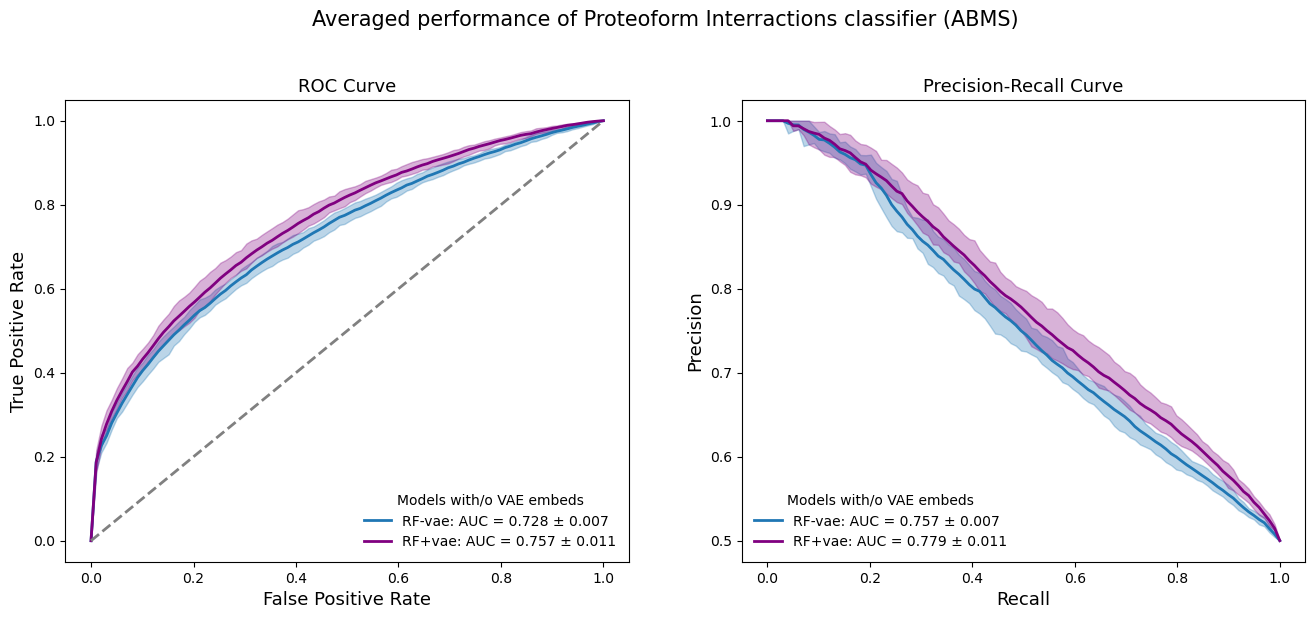

In [80]:
# Plot the mean ROC curves with 95% confidence intervals for both models
fig, (axleft, axright) = plt.subplots(1,2,figsize=(16, 6))
colorlist = ['tab:blue', 'purple']

for num, (model_name, rd) in enumerate(roc_data.items()):
    axleft.plot(rd["mean_fpr"], rd["mean_tpr"],
             lw=2,
             color=colorlist[num],
             label=f'{model_name}: AUC = {rd["mean_auc"]:.3f} ± {rd["std_auc"]:.3f}')
    axleft.fill_between(rd["mean_fpr"], rd["tprs_lower"], rd["tprs_upper"], alpha=0.3, color=colorlist[num])

    axright.plot(rd["mean_rec"], rd["mean_prec"],
             lw=2,
             color=colorlist[num],
             label=f'{model_name}: AUC = {rd["mean_pr_auc"]:.3f} ± {rd["std_pr_auc"]:.3f}')
    axright.fill_between(rd["mean_rec"], rd["pr_prec_lower"], rd["pr_prec_upper"], alpha=0.3, color=colorlist[num])

# Plot the chance line for reference
# Set labels and titles for ROC subplot.
axleft.set_xlabel("False Positive Rate", fontsize=13)
axleft.set_ylabel("True Positive Rate", fontsize=13)
axleft.set_title("ROC Curve", fontsize=13)
axleft.legend(title="Models with/o VAE embeds", loc="lower right",frameon=False)
axleft.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)


# Set labels and title for PR subplot.
axright.set_xlabel("Recall", fontsize=13)
axright.set_ylabel("Precision", fontsize=13)
axright.set_title("Precision-Recall Curve", fontsize=13)
axright.legend(title="Models with/o VAE embeds", loc="lower left", frameon=False)
plt.suptitle(f"Averaged performance of {classifier_type} Interractions classifier ({data_type})",fontsize=15, y=1.03)
plt.show()

## Importances on multiple (10) seeds (skip that part if already done)
- Normally for most confident results I would run them around 100 iterations of different seed to decide which features to keep. 


In [ ]:

selected_cols = abms_selection # top10
scale_data = False
imbalance_factor = None
final_feature_df = pd.DataFrame()

for n, seed in enumerate([123, 453, 62, 569, 888, 501, 102, 89, 912, 732]):
    # if n>2:
    #     break

    seed = seed
    # sample from the data and undersample the negative class by random shuffling
    pos_df = data[data["db"] == 1]
    neg_df = data[data["db"] == 0]

    if imbalance_factor is not None:
        neg_df = neg_df.sample(n=pos_df.shape[0]*imbalance_factor, random_state=seed)
    else:
        neg_df = neg_df.sample(n=pos_df.shape[0], random_state=seed) # 1 to 1 ratio via undersampling 

    data_sample = pd.concat([pos_df, neg_df])
    del pos_df, neg_df

    # shuffle the data
    data_sample = data_sample.sample(frac=1, random_state=seed)

    # subset columns of data df based on regex
    if selected_cols is not None:
        X_df = data_sample[selected_cols]
        X = data_sample[selected_cols]
    else:
        X_df = data_sample.drop(columns=drop_cols)
        X = data_sample.drop(columns=drop_cols)

    y = data_sample["db"]

    # scale the data and create a df again
    if scale_data is True:
        X = StandardScaler().fit_transform(X)
        X = pd.DataFrame(X, columns=X_df.columns)



    # split train-test sets from this seed 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    del X,y,X_df
    gc.collect()

    # here we deal with imbalance if applied
    if imbalance_factor is not None:
        print(f"Operating smote to minority class with a factor of {imbalance_factor}")
        smote = SMOTE(random_state=seed)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        print("Class distribution after SMOTE:")
        print(pd.Series(y_train).value_counts())
    else:
        print("Classifier operates on undersample data")
    cv = StratifiedKFold

    # train a randomforest classifier, set the chosen hyperparaeters 
    rf = RandomForestClassifier(n_estimators=500,
                                max_features=0.3, 
                                criterion="entropy",
                                random_state=seed,
                                min_samples_leaf=1,
                                class_weight="balanced",
                                n_jobs=7)
    rf.fit(X_train, y_train)
    rf.feature_importances_

    y_predprob = rf.predict_proba(X_test)[:,1]
    # print(roc_auc_score(y_test, y_predprob))

    y_pred = rf.predict(X_test)
    # print(classification_report(y_test, y_pred))

    # print(rf.feature_names_in_)


    # feature importance using permutation
    start_time = time.time()
    result = permutation_importance(
        rf, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=7
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    seed_importances_df = pd.DataFrame({
        "features": X_test.columns.to_list(),
        'perm_mean_importance': result.importances_mean,
        'entropy_mean': rf.feature_importances_,
        "seed": seed,
        "auc": roc_auc_score(y_test, y_predprob),
        "recall": round(classification_report(y_test, y_pred, output_dict=True)["1"]["recall"],3)

    })

    final_feature_df = pd.concat([final_feature_df, seed_importances_df], axis=0)


Classifier operates on undersample data
Elapsed time to compute the importances: 26.721 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 20.123 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 22.128 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 24.364 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 24.236 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 21.090 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 20.250 seconds
Classifier operates on undersample data


c:\Users\gpano\anaconda3\envs\scbc3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Elapsed time to compute the importances: 24.265 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 23.699 seconds
Classifier operates on undersample data
Elapsed time to compute the importances: 21.941 seconds


In [82]:
# # save the dataframe with the iteration data for the specific classifier type and data type 
# if data_type == "SCBC":
#     if classifier_type == "Proteoform":
#         final_feature_df.to_csv(os.getcwd()+ "\\data\\features_sim\\" + f"importance_{classifier_type}_{data_type}_iterations.csv", header=True)
#     elif classifier_type == "Protein":
#         final_feature_df.to_csv(os.getcwd()+ "\\data\\features_protein\\" + f"importance_{classifier_type}_{data_type}_iterations.csv", header=True)

# elif data_type == "ABMS":
#     if classifier_type == "Proteoform":
#         final_feature_df.to_csv(os.getcwd()+ "\\data\\features_sim\\" + f"importance_{classifier_type}_{data_type}_iterations.csv", header=True)
#     elif classifier_type == "Protein":
#         final_feature_df.to_csv(os.getcwd()+ "\\data\\features_protein\\" + f"importance_{classifier_type}_{data_type}_iterations.csv", header=True)

# aggregate the result for visualization and plotting below 
agg_features = final_feature_df.groupby(["features"], as_index=False).agg(
    perm_mean=("perm_mean_importance", "mean"),
    perm_std=("perm_mean_importance", "std"),
    entropy_mean=("entropy_mean", "mean"),
    entropy_std=("entropy_mean", "std")
)


In [83]:
final_feature_df.auc.mean(), final_feature_df.auc.std()

(0.7565963140129519, 0.004674481892077232)

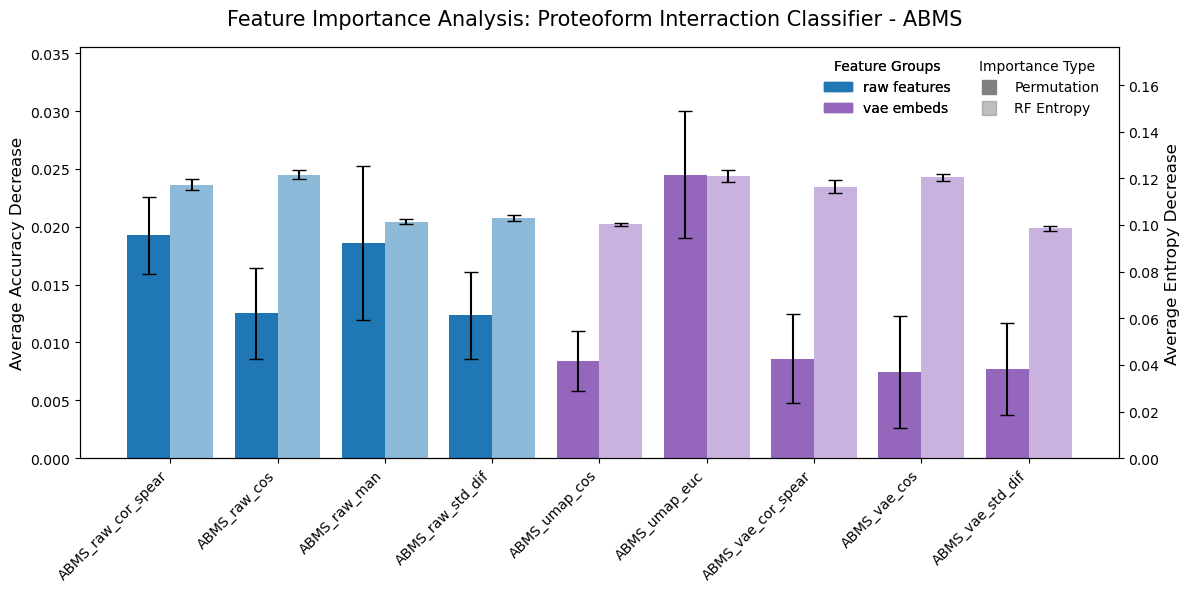

In [84]:
perm_color =["tab:blue" if "raw" in string else "tab:purple" for string in agg_features["features"].values]
entropy_color =["tab:blue" if "raw" in string else "tab:purple" for string in agg_features["features"].values]
perm_alpha = 1.0
entropy_alpha = 0.5
x = np.arange(len(agg_features["features"].values))  # the x locations for the groups
bar_width = 0.4

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for permutation importance
perm_bars = ax.bar(
    x - bar_width/2,
    agg_features["perm_mean"],
    yerr=agg_features["perm_std"],
    color=perm_color,
    alpha=perm_alpha,
    width=bar_width,
    label="Permutation Importance",
    capsize=5
)
ax2 = ax.twinx()
# Plot bars for RF entropy importance
entropy_bars = ax2.bar(
    x + bar_width/2,
    agg_features["entropy_mean"],
    yerr=agg_features["entropy_std"],
    color=entropy_color,
    alpha=entropy_alpha,
    width=bar_width,
    label="RF Entropy Importance",
    capsize=5
)
# Customize the x-axis
ax.set_xticks(x)
ax.set_xticklabels(agg_features["features"].values, rotation=45, ha="right")


# set the same y limits for both axesx
ax.set_ylim(0, 1.45 * agg_features["perm_mean"].max())
ax2.set_ylim(0, 1.45 * max(agg_features["perm_mean"].max(), agg_features["entropy_mean"].max()))

# Labels and legend  ## use manually the handles

# Legend for the alpha differences (importance type)
importance_handles = [
    Line2D([0], [0], marker='s', color='gray', markersize=10, linestyle='None',
           label='Permutation', markerfacecolor='gray', alpha=perm_alpha),
    Line2D([0], [0], marker='s', color='gray', markersize=10, linestyle='None',
           label='RF Entropy', markerfacecolor='gray', alpha=entropy_alpha)
]

# Legend for the color encoding (feature groups)
# add patches for color encoding 
feature_handles = [
    mpatches.Patch(color='tab:blue', label='raw features'),
    mpatches.Patch(color='tab:purple', label='vae embeds')
]

legend1 = ax.legend(handles=importance_handles, loc='upper left', title="Importance Type",
                    frameon=False, bbox_to_anchor=(0.85,1))
ax.add_artist(legend1)
legend2 = ax.legend(handles=feature_handles, loc='upper right', title="Feature Groups",
                    frameon=False, bbox_to_anchor=(0.85,1))
ax.add_artist(legend2)





ax.set_ylabel("Average Accuracy Decrease", fontsize=12)
ax2.set_ylabel("Average Entropy Decrease", fontsize=12)
plt.suptitle(f"Feature Importance Analysis: {classifier_type} Interraction Classifier - {data_type}", fontsize=15)
# ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# extract the features and remove the top list those that are not good 
# data.loc[:,~data.columns.isin(drop_cols)].columns.to_list()

['ABMS_raw_cor_pears',
 'ABMS_raw_cor_spear',
 'ABMS_raw_euc',
 'ABMS_raw_man',
 'ABMS_raw_std_dif',
 'ABMS_umap_cos',
 'ABMS_umap_euc',
 'ABMS_umap_man',
 'ABMS_vae_cor_pears',
 'ABMS_vae_cor_spear',
 'ABMS_vae_cos',
 'ABMS_vae_euc',
 'ABMS_vae_man',
 'ABMS_vae_std_dif']

In [ ]:
# agg_features[agg_features["perm_mean"] - agg_features["perm_std"] > 0].features.values.tolist()

['ABMS_raw_cor_spear',
 'ABMS_umap_cos',
 'ABMS_umap_euc',
 'ABMS_umap_man',
 'SCBC_raw_cor_pears',
 'SCBC_raw_cor_spear',
 'SCBC_raw_man',
 'SCBC_raw_std_dif',
 'SCBC_umap_euc',
 'SCBC_umap_man',
 'SCBC_vae_cor_pears',
 'SCBC_vae_cor_spear',
 'SCBC_vae_cos',
 'SCBC_vae_euc',
 'SCBC_vae_man']